In [240]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip
import tensorflow as tf
import glob
import math
import skimage

In [2]:
tf.enable_eager_execution()

## Specify the Experiment Directory

In [298]:
common_dir = '/home/justinvyu/ray_results'
universe = 'gym'
domain = 'Point2D'
task = 'BoxWall-v1'

In [367]:
base_path = os.path.join(common_dir, universe, domain, task)
exps = sorted(list(glob.iglob(os.path.join(base_path, '*'))))
for i, exp in enumerate(exps):
    print(f'{i} \t {exp.replace(base_path, "")}')
    
exp_choice = int(input('\n Which experiment do you want to analyze? (ENTER A NUMBER) \t'))

exp_path = exps[exp_choice]
print('\n')
seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
seeds = [seed for seed in seeds if os.path.isdir(seed)]
for i, seed in enumerate(seeds):
    print(f'{i} \t {seed.replace(exp_path, "")}')
    
# TODO: Extend to analyzing all seeds
seed_choice = int(input('\n Which seed do you want to analyze? (ENTER A NUMBER) \t'))

seed_path = seeds[seed_choice]

print('PATH:\n', seed_path)

0 	 /2020-03-14T16-43-26-sac_actionscales_rewards_boxwall
1 	 /2020-03-14T18-28-09-vice_actionscales_randreset_1goal_boxwall_50path
2 	 /2020-03-15T22-10-17-sac_actionscales_rewards_boxwall_delete_later
3 	 /2020-03-15T22-11-01-sac_actionscales_rewards_boxwall_delete_later
4 	 /2020-03-15T22-12-10-sac_actionscales_rewards_boxwall_delete_later
5 	 /2020-03-15T22-13-47-sac_actionscales_rewards_boxwall_delete_later
6 	 /2020-03-15T22-16-30-sac_actionscales_rewards_boxwall_delete_later
7 	 /2020-03-15T22-17-29-sac_actionscales_rewards_boxwall_delete_later
8 	 /2020-03-15T22-20-51-sac_actionscales_rewards_boxwall_delete_later
9 	 /2020-03-15T22-23-53-sac_actionscales_rewards_boxwall_delete_later
10 	 /2020-03-15T22-40-16-sac_actionscales_rewards_boxwall_delete_later
11 	 /2020-03-17T16-18-54-vice_randreset_bottommiddle

 Which experiment do you want to analyze? (ENTER A NUMBER) 	11


0 	 /ac505f9a-algorithm=VICE-seed=2352_2020-03-17_16-18-55qqvzbsr5
1 	 /ac50f6b2-algorithm=VICE-seed=9793_20

## Specify the Checkpoint

In [368]:
checkpoint_to_analyze = 100

In [369]:
with open(os.path.join(seed_path, f'checkpoint_{checkpoint_to_analyze}/checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)

W0317 17:14:04.153533 139731411531584 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


## Load Reward Classifier

In [370]:
reward_clf = checkpoint['reward_classifier']

In [371]:
train_env = checkpoint['training_environment']

In [372]:
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

In [373]:
n_samples = 50
xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

xys = np.meshgrid(xs, ys)

In [374]:
grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))

In [375]:
rewards = reward_clf.predict(grid_vals)

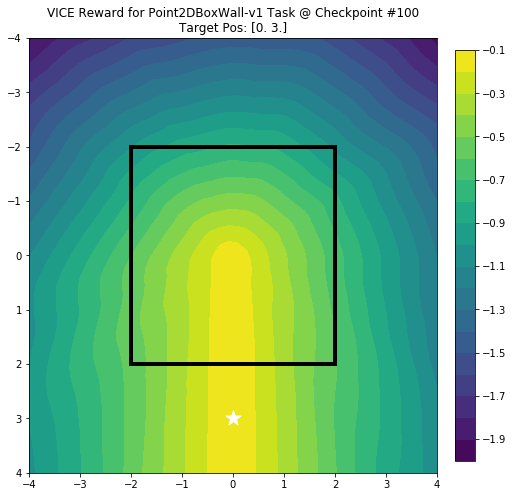

In [378]:
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle
plt.gca().invert_yaxis()

plt.contourf(xys[0], xys[1], rewards.reshape(xys[0].shape), levels=20)
plt.colorbar(fraction=0.046, pad=0.04)

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))

plt.scatter(*target_pos, marker='*', s=250, color='white')
plt.title(f'VICE Reward for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

## Plot Goal Examples

In [379]:
with open('/home/justinvyu/dev/vice/goal_classifier/pointmass_nowalls/bottom_middle/positives.pkl', 'rb') as f:
    data = pickle.load(f)

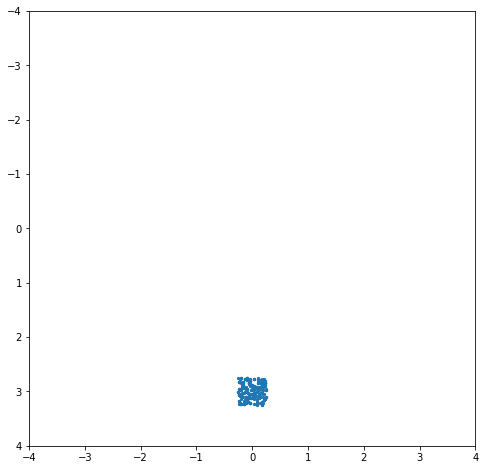

In [380]:
plt.figure(figsize=(8, 8))

plt.scatter(data['state_observation'][:,0], data['state_observation'][:,1], s=5)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.gca().invert_yaxis()

## Plot Ground Truth Rewards

In [ ]:
feed_dict = {
    'state_achieved_goal': grid_vals,
    'state_desired_goal': np.full(grid_vals.shape, fill_value=2)
}
train_env.unwrapped.reward_type = 'sparse'
gtr = train_env.unwrapped.compute_rewards(None, feed_dict)
plt.figure(figsize=(8, 8))

from matplotlib.patches import Rectangle

plt.gca().invert_yaxis()

plt.contourf(xys[0], xys[1], gtr.reshape(xys[0].shape))
plt.colorbar(fraction=0.046, pad=0.04)

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))

plt.title(f'Ground Truth Reward for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}')

plt.scatter(*target_pos, marker='*', s=250, color='white')
plt.show()